##Analyzing a Real Binding Dataset

Here we use the same methods described in the previous notebook 'Simulating a Binding Dataset' to analyze a real binding dataset.

This notebook is based on the more in depth notebook in the main branch of assaytools [here](https://github.com/choderalab/assaytools/blob/master/examples/ipynbs/data-analysis/binding-assay/Src-gefitinib%20fluorescence%20simple.ipynb).

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from assaytools import platereader
import string

from scipy import optimize
import seaborn as sns

%pylab inline

Couldn't import dot_parser, loading of dot files will not be possible.
Populating the interactive namespace from numpy and matplotlib


/Users/hansons/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
Pstated = 0.5e-6 * np.ones([24],np.float64) # protein concentration, M
Lstated = np.array([20.0e-6,14.0e-6,9.82e-6,6.88e-6,4.82e-6,3.38e-6,2.37e-6,1.66e-6,1.16e-6,0.815e-6,0.571e-6,0.4e-6,0.28e-6,0.196e-6,0.138e-6,0.0964e-6,0.0676e-6,0.0474e-6,0.0320e-6,0.0240e-6,0.0160e-6,0.0120e-6,0.008e-6,0.00001e-6], np.float64) # ligand concentration, M

In [6]:
ls

Analyzing a Real Binding Dataset.ipynb  complex_Fluorescence.png
README.md                               complex_ligand.png
Simulating a Binding Dataset.ipynb      p38_8lig1_20160426_120449.xml*


In [11]:
#Importing our data file.
#singlet_file = 'p38_8lig1_20160426_120449.xml'
singlet_file = 'p38_singlet1_20160420_153238.xml'

In [12]:
#Parsing our data file so it's in a format we can analyze it.
data = platereader.read_icontrol_xml(singlet_file)
#I want the Bosutinib-p38 data from rows I (protein) and J (buffer).
data_protein = platereader.select_data(data, '280_480_TOP_120', 'I')
data_buffer = platereader.select_data(data, '280_480_TOP_120', 'J')

In [13]:
data_protein

{'I1': '16546',
 'I10': '8280',
 'I11': '7005',
 'I12': '5827',
 'I13': '4967',
 'I14': '4378',
 'I15': '3859',
 'I16': '3513',
 'I17': '3176',
 'I18': '3001',
 'I19': '2855',
 'I2': '16009',
 'I20': '2736',
 'I21': '2647',
 'I22': '2552',
 'I23': '2515',
 'I24': '2487',
 'I3': '15707',
 'I4': '14688',
 'I5': '14146',
 'I6': '12881',
 'I7': '12583',
 'I8': '11251',
 'I9': '10015'}

In [14]:
#Sadly we also need to reorder our data and put it into an array to make the analysis easier

well = dict()
for j in string.ascii_uppercase:
    for i in range(1,25):
        well['%s' %j + '%s' %i] = i

def reorder2list(data,well):
    
    sorted_keys = sorted(well.keys(), key=lambda k:well[k])
    
    reorder_data = []
    
    for key in sorted_keys:
        try:
            reorder_data.append(data[key])
        except:
            pass

    reorder_data = [r.replace('OVER','70000') for r in reorder_data]
        
    reorder_data = np.asarray(reorder_data,np.float64)
    
    return reorder_data

reorder_protein = reorder2list(data_protein,well)
reorder_buffer = reorder2list(data_buffer,well)

In [15]:
reorder_protein

array([ 16546.,  16009.,  15707.,  14688.,  14146.,  12881.,  12583.,
        11251.,  10015.,   8280.,   7005.,   5827.,   4967.,   4378.,
         3859.,   3513.,   3176.,   3001.,   2855.,   2736.,   2647.,
         2552.,   2515.,   2487.])

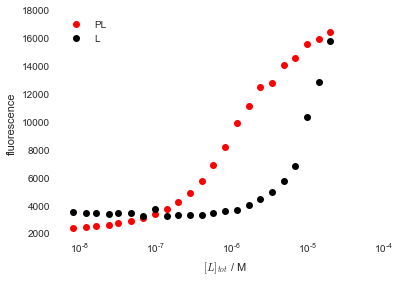

In [16]:
plt.semilogx(Lstated,reorder_protein, 'ro', label='PL')
plt.semilogx(Lstated,reorder_buffer, 'ko', label='L')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('fluorescence')
plt.xlim(5e-9,1.3e-4)
plt.legend(loc=2);

# Analyze with MLE

In [17]:
def two_component_binding(Kd, Ptot, Ltot):
    """
    Parameters
    ----------
    Kd : float
        Dissociation constant
    Ptot : float
        Total protein concentration
    Ltot : float
        Total ligand concentration
        
    Returns
    -------
    P : float
        Free protein concentration
    L : float
        Free ligand concentration
    PL : float
        Complex concentration
    """
                                    
    PL = 0.5 * ((Ptot + Ltot + Kd) - np.sqrt((Ptot + Ltot + Kd)**2 - 4*Ptot*Ltot))  # complex concentration (uM)
    P = Ptot - PL; # free protein concentration in sample cell after n injections (uM)                                                                                                                                                                                                                          
    L = Ltot - PL; # free ligand concentration in sample cell after n injections (uM)                                                                                                                                                                                                                           
    return [P, L, PL]

In [18]:
def find_Kd_from_fluorescence(params):
    
    [F_background, F_PL, Kd] = params
    
    N = len(Lstated)
    Fmodel_i = np.zeros([N])
    
    for i in range(N):
        [P, L, PL] = two_component_binding(Kd, Pstated[0], Lstated[i])
        Fmodel_i[i] = (F_PL*PL + F_L*L) + F_background
    
    return Fmodel_i

In [19]:
# for this to work we need to provide some initial values
# some of these we already have
#F_L = reorder_buffer
#F_PL = reorder_protein

#And makeup an F_L
F_L = 0.3

# initial guess for [F_background, F_PL, Kd]
initial_guess = [0,400/1e-9,2e-9]

In [20]:
def sumofsquares(params):
    prediction = find_Kd_from_fluorescence(params)
    return np.sum((prediction - reorder_protein)**2)

In [21]:
initial_guess = [0,3e11,1e-9]
fit = optimize.minimize(sumofsquares,initial_guess,method='Nelder-Mead')
print "The predicted parameters [F_background, F_PL, Kd] are ", fit.x

The predicted parameters [F_background, F_PL, Kd] are  [  2.49844795e+03   2.86577268e+10   8.76906192e-07]


In [22]:
fit.x[0]

2498.4479462972331

In [23]:
initial_guess

[0, 300000000000.0, 1e-09]

In [24]:
fit_prediction = find_Kd_from_fluorescence(fit.x)

/Users/hansons/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


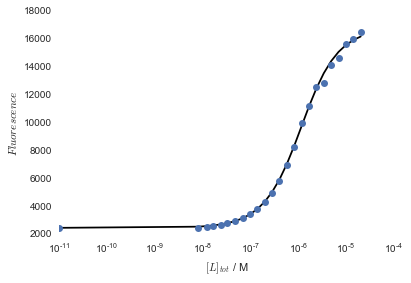

In [25]:
plt.semilogx(Lstated,fit_prediction,color='k')
plt.semilogx(Lstated,reorder_protein, 'o')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescence$')
plt.legend();

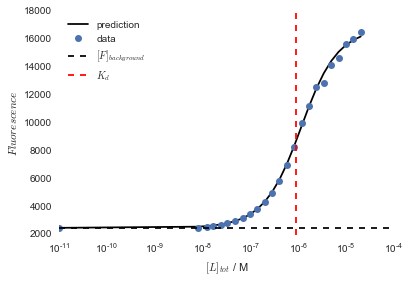

In [26]:
plt.semilogx(Lstated,fit_prediction,color='k', label='prediction')
plt.semilogx(Lstated,reorder_protein, 'o', label='data')
plt.axhline(fit.x[0],color='k',linestyle='--', label='$[F]_{background}$')
plt.axvline(fit.x[2],color='r',linestyle='--', label='$K_d$')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescence$')
plt.legend(loc=2);

In [27]:
Kd_MLE = fit.x[2]

In [28]:
if (Kd_MLE < 1e-12):
    Kd_summary = "Kd = %.1f nM " % (Kd_MLE/1e-15)
elif (Kd_MLE < 1e-9):
    Kd_summary = "Kd = %.1f pM " % (Kd_MLE/1e-12)
elif (Kd_MLE < 1e-6):
    Kd_summary = "Kd = %.1f nM " % (Kd_MLE/1e-9)
elif (Kd_MLE < 1e-3):
    Kd_summary = "Kd = %.1f uM " % (Kd_MLE/1e-66)
elif (Kd_MLE < 1):
    Kd_summary = "Kd = %.1f mM " % (Kd_MLE/1e-3)
else:
    Kd_summary = "Kd = %.3e M " % (Kd_MLE)

In [29]:
Kd_summary

'Kd = 876.9 nM '

In [30]:
delG_summary = "delG = %s kT" %np.log(Kd_MLE)
delG_summary 

'delG = -13.9468658149 kT'

# Analyze with our simple bayesian model

In [31]:
# we also need assay_volume for this
assay_volume = 50e-6 # assay volume, L

In [32]:
# and an estimate for the uncertainties protein and ligand concentrations
dPstated = 0.35 * Pstated # protein concentration uncertainty
dLstated = 0.08 * Lstated # ligand concentraiton uncertainty (due to gravimetric preparation and HP D300 dispensing)


In [33]:
from assaytools import pymcmodels
pymc_model = pymcmodels.make_model(Pstated, dPstated, Lstated, dLstated, 
    top_complex_fluorescence=reorder_protein,
    top_ligand_fluorescence=reorder_buffer,
    use_primary_inner_filter_correction=True, 
    use_secondary_inner_filter_correction=True, 
    assay_volume=assay_volume, DG_prior='uniform')
            
mcmc = pymcmodels.run_mcmc(pymc_model)
            
map = pymcmodels.map_fit(pymc_model)
    
pymcmodels.show_summary(pymc_model, map, mcmc)
    
DeltaG = mcmc.DeltaG.trace().mean()
dDeltaG = mcmc.DeltaG.trace().std()

MAP fitting cycle 5/5
DeltaG = -15.4 +- 2.9 kT
Kd = 213.4 nM +- 201.3 nM


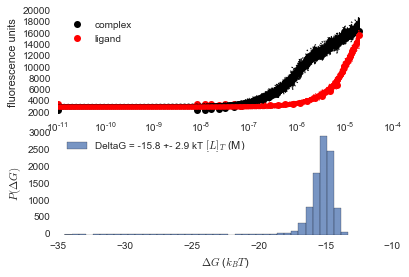

In [34]:
#from assaytools import plots
plt.subplot(211)
property_name = 'top_complex_fluorescence'
complex = getattr(pymc_model, property_name)
plt.semilogx(Lstated, complex.value, 'ko',label='complex')
property_name = 'top_ligand_fluorescence'
ligand = getattr(pymc_model, property_name)
plt.semilogx(Lstated, ligand.value, 'ro',label='ligand')
for top_complex_fluorescence_model in mcmc.top_complex_fluorescence_model.trace()[::10]:
    plt.semilogx(Lstated, top_complex_fluorescence_model, 'k:')
for top_ligand_fluorescence_model in mcmc.top_ligand_fluorescence_model.trace()[::10]:
    plt.semilogx(Lstated, top_ligand_fluorescence_model, 'r:')
plt.xlabel('$[L]_T$ (M)');
plt.ylabel('fluorescence units');
plt.legend(loc=0);
#figure = plots.plot_measurements(Lstated, Pstated, pymc_model, mcmc=mcmc)
plt.subplot(212)
plt.hist(mcmc.DeltaG.trace(), 40, alpha=0.75, label="DeltaG = %.1f +- %.1f kT"%(DeltaG, dDeltaG))            
plt.legend(loc=0)
plt.xlabel('$\Delta G$ ($k_B T$)');
plt.ylabel('$P(\Delta G)$');

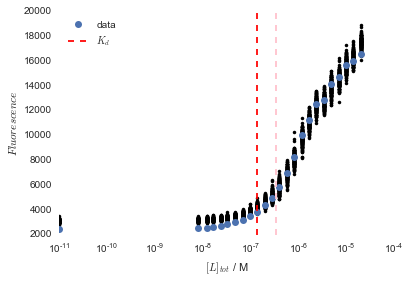

In [35]:
# Let's plot this the same as our MLE for a better comparison

Kd_bayes = np.exp(mcmc.DeltaG.trace().mean())
dKd_bayes = np.exp(mcmc.DeltaG.trace()).std()

for top_complex_fluorescence_model in mcmc.top_complex_fluorescence_model.trace()[::50]:
    plt.semilogx(Lstated, top_complex_fluorescence_model, 'k.')
#plt.semilogx(Lstated,mcmc.top_complex_fluorescence_model.trace()[::10],color='k', label='prediction')
plt.semilogx(Lstated,reorder_protein, 'o', label='data')
#plt.axhline(fit.x[0],color='k',linestyle='--', label='$[F]_{background}$')
plt.axvline(Kd_bayes,color='r',linestyle='--', label='$K_d$')
plt.axvline(Kd_bayes+dKd_bayes,color='pink',linestyle='--')
plt.axvline(Kd_bayes-dKd_bayes,color='pink',linestyle='--')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescence$')
plt.legend(loc=2);